In [1]:
import pandas as pd
import numpy as np
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
from collections import namedtuple

In [384]:
%run ../modules/utils.ipynb
%run ../modules/cds.ipynb
%run ../modules/preprocessing.ipynb

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

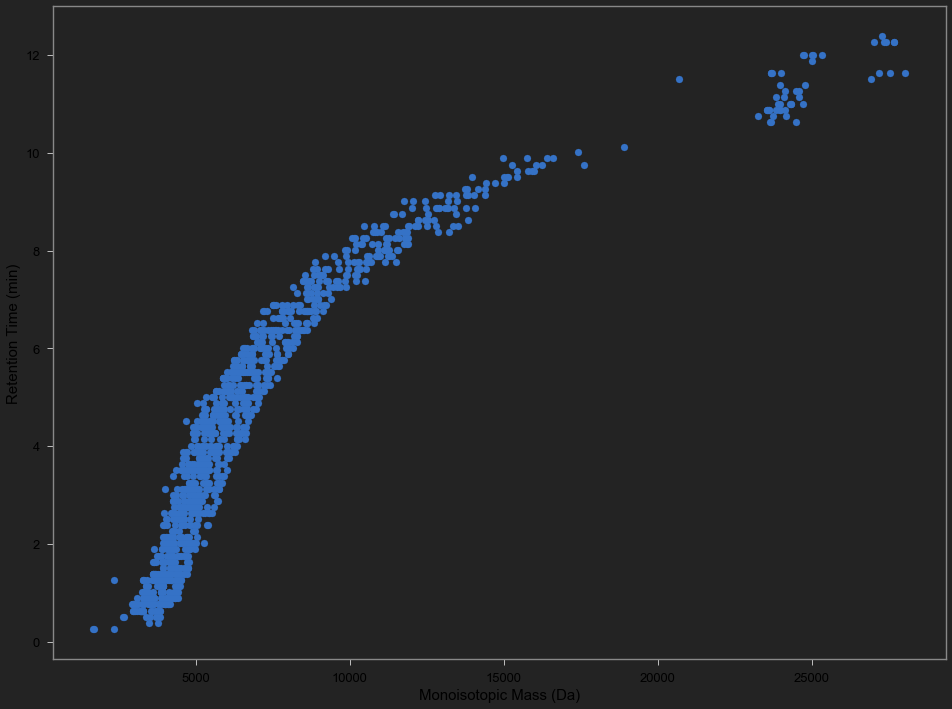

In [389]:
df = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/Data/Excels/total_tRNA_acid_degradated_20to40_component_only.xlsx')
# df = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/BaoLab/SecondBatch/Analysis/rsv_25k.xlsx')
# df = pd.read_excel('/Users/bryan/Documents/BioPharmaFinder/ZhangLab/oligosdegradsample2-1.xlsx')
df.shape
df = thermo_df(df)
plot_zone(df)

<Figure size 576x504 with 0 Axes>

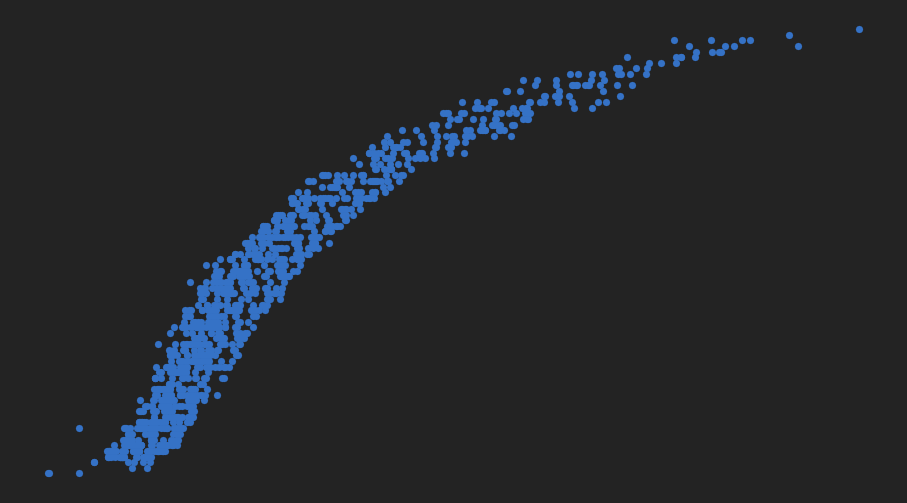

In [390]:
plt.figure(frameon=False)
_, ax = plt.subplots(figsize=(16, 9))
# ax.figure(figsize=(16, 12))
ax.set_axis_off()
df_main = df[df.Mass < 20000]
plt.scatter(df_main.Mass, df_main.RT)
plt.savefig('/Users/bryan/Downloads/df.png', transparent=True)

mass_x (49,) mass_y (49,)
df3_idxs 4 df5_idxs 4
df3_idxs 2 df5_idxs 2
df3_idxs 0 df5_idxs 0
df3_idxs 1 df5_idxs 1
df3_idxs 1 df5_idxs 1
df3_idxs 1 df5_idxs 1
df3_idxs 2 df5_idxs 2
df3_idxs 0 df5_idxs 0


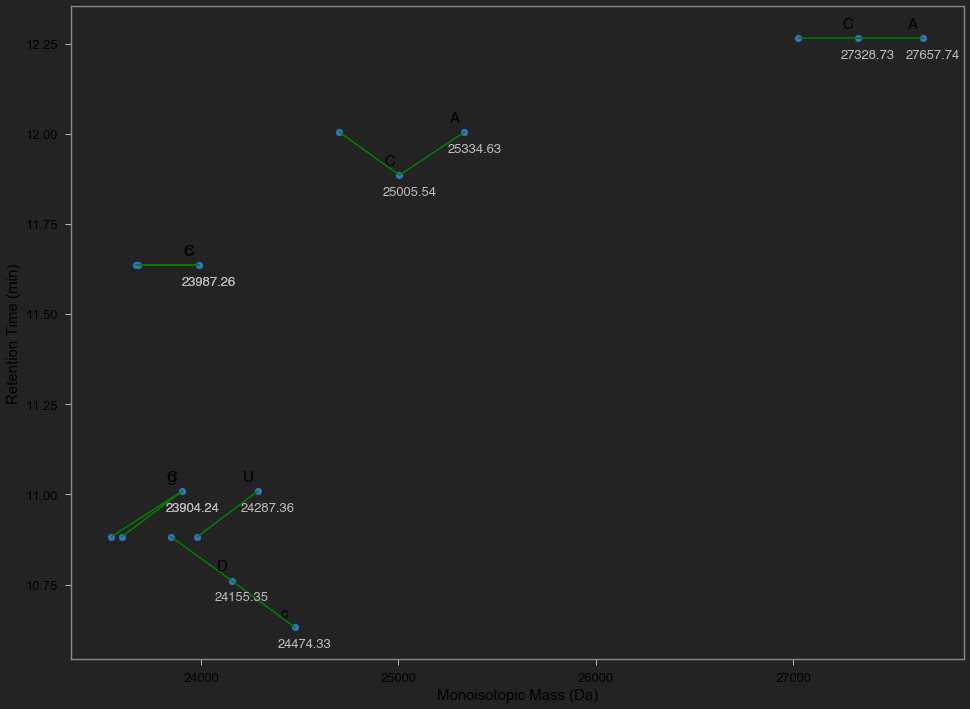

In [391]:
bcr_5p = base_calling_random(df[df.Mass>22000])
plt, _ = plot_basecalling(*bcr_5p, annotate=True)

mass_x (1243,) mass_y (1243,)
df3_idxs 309 df5_idxs 310
df3_idxs 270 df5_idxs 271
df3_idxs 296 df5_idxs 295
df3_idxs 298 df5_idxs 298
df3_idxs 148 df5_idxs 148
df3_idxs 120 df5_idxs 121
df3_idxs 160 df5_idxs 159
df3_idxs 170 df5_idxs 170


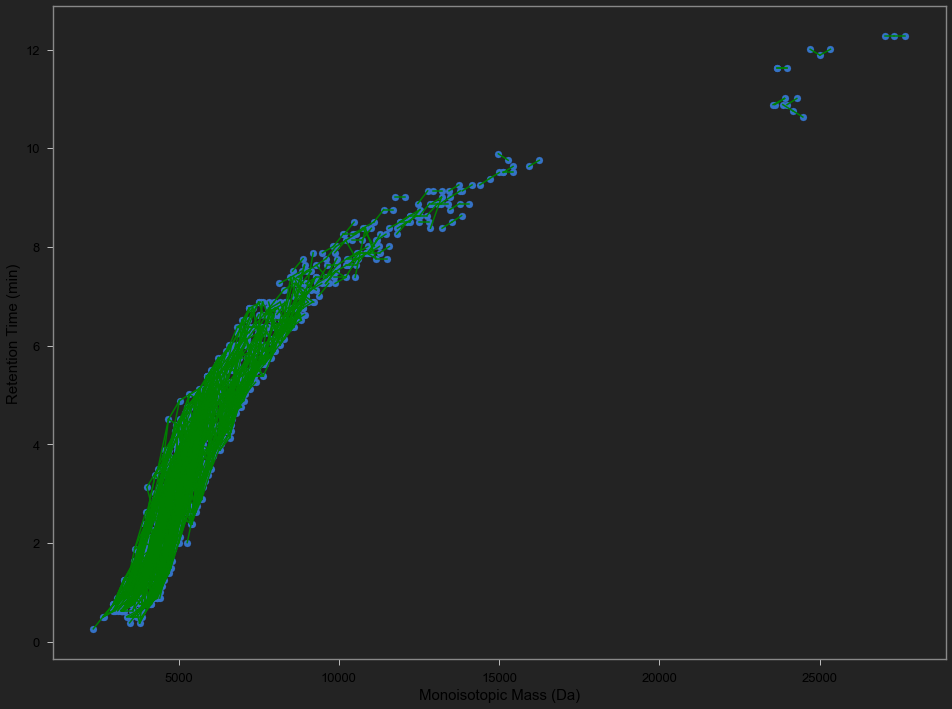

In [392]:
bcr_5p = base_calling_random(df)
plt, _ = plot_basecalling(*bcr_5p, annotate=False)

# Single Filter

In [698]:
mass_win_loc = 6500
mass_win_size = 100

<module 'matplotlib.pyplot' from '/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/matplotlib/pyplot.py'>

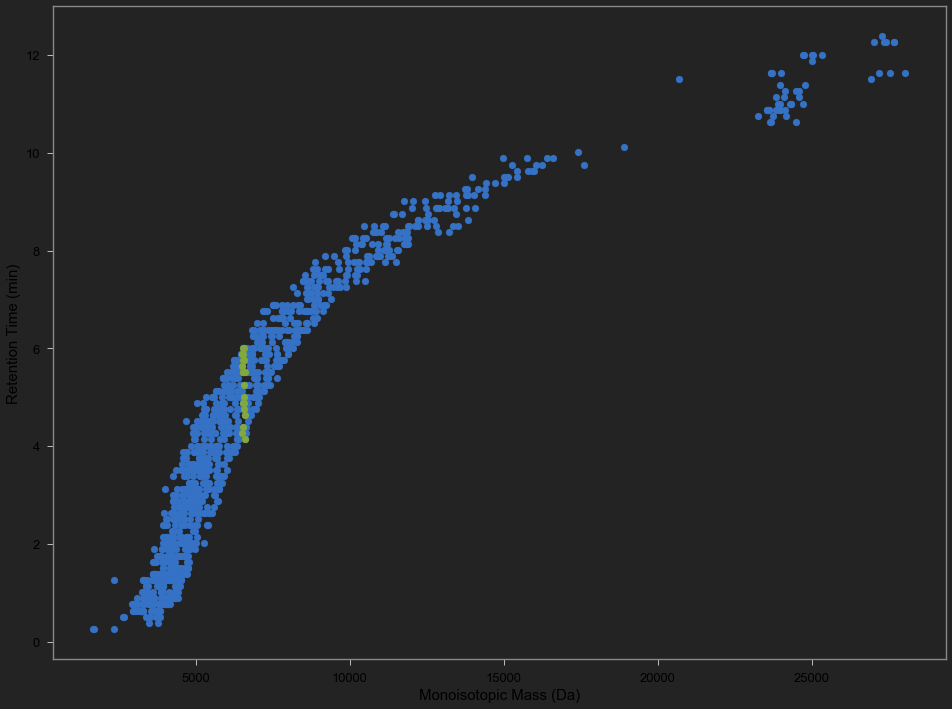

In [699]:
df_win = df[(df.Mass > mass_win_loc) & (df.Mass < mass_win_loc + mass_win_size)]
df_win.shape
plot_zones(df, df_win)

In [700]:
def bin_range(df, bin_num):
    rt = df.RT
    if rt.empty:
        return 0.0, 0.0
    rt_min = rt.min()
    rt_max = rt.max()
    rt_height = rt_max - rt_min
#     print(rt_min, rt_max, rt_height)
    
    bin_size = rt_height / 5.
    bin_size = 0.5 if bin_size < 0.5 else bin_size

    bins = rt_height / rt_win_size
    
    rt_hi = rt_max - bin_size * (bin_num - 1)
    rt_lo = rt_hi - bin_size
#     print(type(rt_lo), type(bin_size))
    if np.less(rt_lo, rt_min):
        print('Reach the last bin.')
        rt_lo = rt_min
        rt_hi = rt_lo + bin_size
    print('df_win count {} RT lo-hi {}-{}'.format(df.shape[0], rt_lo, rt_hi))
    return rt_lo, rt_hi

df_win count 19 winRT 3.9112195242838204-6.2192209691101485 filterRT lo-hi 5.757620680144883-6.2192209691101485
(6, 3)


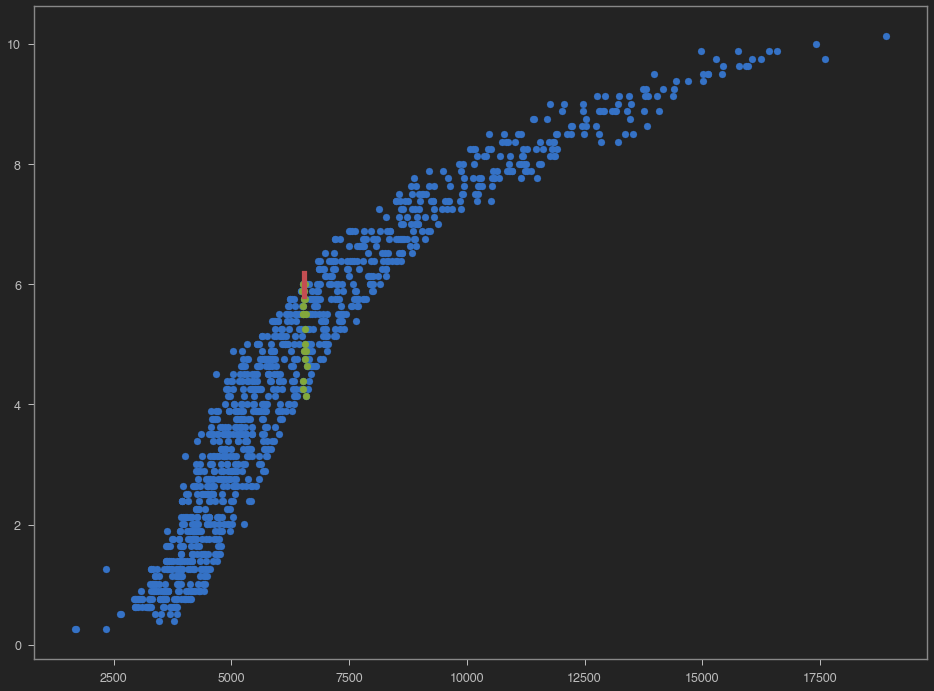

In [721]:
# rt_lo, rt_hi = bin_range(df_win, 1)
rt_lo, rt_hi = bin_range2(df_win, mass_win_loc, mass_win_loc+mass_win_size, f_hi2, f_lo2, 1)
df_filter = df_win[(df_win.RT<=rt_hi) & (df_win.RT>=rt_lo)]
print(df_filter.shape)
# plt = plot_zones(df_win, df_filter)
fig, ax = plt.subplots(1, figsize=(16, 12))
rect = create_rectangle(mass_win_loc, mass_win_loc+mass_win_size, rt_lo, rt_hi)
ax.add_patch(rect)
# ax.scatter(df_win.Mass, df_win.RT)
ax.scatter(df_sample.Mass, df_sample.RT)
ax.scatter(df_win.Mass, df_win.RT)

# Sliding Filter

In [397]:
df.Mass.max()

28022.8492309975

In [398]:
import matplotlib.patches as patches

In [705]:
def create_rectangle(left, right, lo, hi):
    rect = patches.Rectangle((left, lo), right-left, hi-lo, color='r')
    return rect

In [497]:
df_sample.RT.min(), df_sample.RT.max()

(0.262746601867676, 10.1296289101919)

In [687]:
filter_min = 0.3
filter_nums = 5

def bin_range2(df, left, right, f_hi, f_lo, bin_num):
    rt = df.RT
    if rt.empty:
        return 0.0, 0.0
#     rt_min = rt.min()
#     rt_max = rt.max()
    rt_min = f_lo(left)
    rt_min = 0.26 if rt_min < 0.26 else rt_min
    rt_max = f_hi(right)
    rt_max = 10.13 if rt_max > 10.13 else rt_max
    rt_height = rt_max - rt_min
#     print(rt_min, rt_max, rt_height)
    
    bin_size = rt_height / filter_nums
    bin_size = filter_min if bin_size < filter_min else bin_size

    bins = rt_height / rt_win_size
    
    rt_hi = rt_max - bin_size * (bin_num - 1)
    rt_lo = rt_hi - bin_size
#     print(type(rt_lo), type(bin_size))
    if np.less(rt_lo, rt_min):
        print('Reach the last bin.')
        rt_lo = rt_min
        rt_hi = rt_lo + bin_size
    print('df_win count {} winRT {}-{} filterRT lo-hi {}-{}'.format(df.shape[0], rt_min, rt_max, rt_lo, rt_hi))
    return rt_lo, rt_hi

Reach the last bin.
df_win count 1 winRT 0.26--1.4678420571320996 filterRT lo-hi 0.26-0.56
Reach the last bin.
df_win count 1 winRT 0.26--1.4034690604349511 filterRT lo-hi 0.26-0.56
Reach the last bin.
df_win count 2 winRT 0.26--0.09858281909736241 filterRT lo-hi 0.26-0.56
Reach the last bin.
df_win count 1 winRT 0.26-0.5098061215067172 filterRT lo-hi 0.26-0.56
Reach the last bin.
df_win count 1 winRT 0.26-0.5482780197921387 filterRT lo-hi 0.26-0.56
df_win count 1 winRT 0.26-1.0768637511088506 filterRT lo-hi 0.47686375110885054-0.7768637511088505
df_win count 2 winRT 0.26-1.0953941766427877 filterRT lo-hi 0.4953941766427877-0.7953941766427877
df_win count 2 winRT 0.26-1.1139005216445192 filterRT lo-hi 0.5139005216445192-0.8139005216445192
df_win count 1 winRT 0.26-1.1323827761738818 filterRT lo-hi 0.5323827761738817-0.8323827761738818
df_win count 1 winRT 0.26-1.1508409303708809 filterRT lo-hi 0.5508409303708808-0.8508409303708808
df_win count 1 winRT 0.26-1.1692749744556976 filterRT l

df_win count 5 winRT 0.26-2.777168430844283 filterRT lo-hi 1.7703010585065697-2.2737347446754264
df_win count 5 winRT 0.26-2.793303912569123 filterRT lo-hi 1.7799823475414738-2.2866431300552983
df_win count 2 winRT 0.26-2.809414720686601 filterRT lo-hi 1.7896488324119608-2.299531776549281
df_win count 5 winRT 0.2721329003204854-2.825500853113477 filterRT lo-hi 1.80415367199628-2.3148272625548785
df_win count 2 winRT 0.2875985141622369-2.8415623078466923 filterRT lo-hi 1.8199767903729103-2.3307695491098013
df_win count 3 winRT 0.3030591494916607-2.857599082963349 filterRT lo-hi 1.8357831095746735-2.3466910962690113
df_win count 1 winRT 0.31851474511263034-2.873611176620735 filterRT lo-hi 1.8515726040174927-2.3625918903191137
df_win count 3 winRT 0.3339652399668763-2.889598587056302 filterRT lo-hi 1.867345248220532-2.378471917638417
df_win count 1 winRT 0.34941057313397883-2.905561312587681 filterRT lo-hi 1.8831010168062003-2.3943311646969407
df_win count 3 winRT 0.3648506838313704-2.921

df_win count 3 winRT 2.148642070936662-4.642107127012869 filterRT lo-hi 3.644721104582386-4.143414115797627
df_win count 3 winRT 2.1630549033778617-4.655094823503697 filterRT lo-hi 3.658278855453363-4.15668683947853
df_win count 2 winRT 2.1774561761473676-4.668058231377035 filterRT lo-hi 3.6718174092851683-4.169937820331102
df_win count 3 winRT 2.1918458452806076-4.680997358811757 filterRT lo-hi 3.6853367533992967-4.1831670561055265
df_win count 4 winRT 2.2062238669508587-4.693912214066913 filterRT lo-hi 3.698836875220491-4.196374544643702
df_win count 3 winRT 2.220590197469256-4.7068028054817255 filterRT lo-hi 3.712317762276738-4.209560283879232
df_win count 3 winRT 2.234944793284781-4.7196691414755865 filterRT lo-hi 3.725779402199264-4.222724271837425
df_win count 1 winRT 2.2492876109842688-4.732511230548065 filterRT lo-hi 3.7392217827225465-4.235866506635306
df_win count 2 winRT 2.263618607292409-4.745329081278896 filterRT lo-hi 3.7526448916843016-4.248986986481599
df_win count 1 wi

df_win count 4 winRT 4.073634632015514-6.257987297738916 filterRT lo-hi 5.384246231449556-5.821116764594236
df_win count 4 winRT 4.086013841017563-6.267623019768905 filterRT lo-hi 5.394979348268368-5.831301184018637
df_win count 2 winRT 4.098376603029385-6.277236436754567 filterRT lo-hi 5.405692503264493-5.84146447000953
df_win count 1 winRT 4.1107228937993-6.2868275683394845 filterRT lo-hi 5.416385698523412-5.851606633431448
df_win count 1 winRT 4.123052689213482-6.296396434247402 filterRT lo-hi 5.427058936233834-5.861727685240618
df_win count 4 winRT 4.135365965295955-6.305943054282249 filterRT lo-hi 5.437712218687732-5.871827636484991
df_win count 1 winRT 4.147662698208599-6.315467448328123 filterRT lo-hi 5.448345548280313-5.881906498304218
df_win count 2 winRT 4.159942864251141-6.324969636349289 filterRT lo-hi 5.4589589275100305-5.89196428192966
df_win count 2 winRT 4.172206439861165-6.334449638390197 filterRT lo-hi 5.469552358978584-5.90200099868439
df_win count 2 winRT 4.19668372

df_win count 1 winRT 5.667604911762028-7.420145192092095 filterRT lo-hi 6.719129079960068-7.069637136026081
df_win count 1 winRT 5.706881177651308-7.4467684231475015 filterRT lo-hi 6.750813524949024-7.098790974048263
df_win count 1 winRT 5.716653933534301-7.4533776817069075 filterRT lo-hi 6.758688182437865-7.106032932072386
df_win count 1 winRT 5.745860989213844-7.473094240554577 filterRT lo-hi 6.782200940018283-7.12764759028643
df_win count 2 winRT 5.7652396448750665-7.486146247719457 filterRT lo-hi 6.797783606581701-7.141964927150579
df_win count 1 winRT 5.784544095668853-7.499124658333141 filterRT lo-hi 6.813292433267426-7.1562085458002835
df_win count 1 winRT 5.803774315761704-7.512029727355015 filterRT lo-hi 6.82872756271769-7.170378645036353
df_win count 1 winRT 5.813361581825415-7.518454838794586 filterRT lo-hi 6.836417536006918-7.177436187400752
df_win count 2 winRT 5.870495198091968-7.556623614967062 filterRT lo-hi 6.8821722482170244-7.219397931592043
df_win count 2 winRT 5.87

df_win count 2 winRT 7.363250539750792-8.485133529904354 filterRT lo-hi 7.885133529904354-8.185133529904354
df_win count 1 winRT 7.375207795266798-8.49215090505794 filterRT lo-hi 7.89215090505794-8.19215090505794
df_win count 1 winRT 7.381161968260352-8.49564441693444 filterRT lo-hi 7.895644416934439-8.195644416934439
df_win count 1 winRT 7.387099871681436-8.499127876218147 filterRT lo-hi 7.899127876218146-8.199127876218146
df_win count 1 winRT 7.393021530905234-8.502601331414835 filterRT lo-hi 7.902601331414835-8.202601331414835
df_win count 1 winRT 7.410689299212557-8.512962158743042 filterRT lo-hi 7.912962158743041-8.212962158743041
df_win count 1 winRT 7.434020468412456-8.526639494675882 filterRT lo-hi 7.926639494675881-8.226639494675881
df_win count 1 winRT 7.44558973018421-8.533420287406395 filterRT lo-hi 7.933420287406395-8.233420287406394
df_win count 1 winRT 7.474233657516367-8.550206629072859 filterRT lo-hi 7.950206629072858-8.250206629072858
df_win count 1 winRT 7.4968633919

df_win count 1 winRT 8.635367812115426-9.381142661503583 filterRT lo-hi 8.781142661503582-9.081142661503582
df_win count 1 winRT 8.646535827900815-9.393793211010864 filterRT lo-hi 8.793793211010863-9.093793211010864
df_win count 1 winRT 8.654899178502317-9.403380480330673 filterRT lo-hi 8.803380480330672-9.103380480330673
df_win count 1 winRT 8.657684920422879-9.406595557154438 filterRT lo-hi 8.806595557154436-9.106595557154437
df_win count 1 winRT 8.671601460392544-9.422819190418613 filterRT lo-hi 8.822819190418612-9.122819190418612
df_win count 1 winRT 8.732789814936213-9.497346362234785 filterRT lo-hi 8.897346362234783-9.197346362234784
df_win count 1 winRT 8.738365491902067-9.504393089971503 filterRT lo-hi 8.904393089971501-9.204393089971502
df_win count 1 winRT 8.743945882858595-9.5114877145471 filterRT lo-hi 8.911487714547098-9.211487714547099
df_win count 1 winRT 8.752326603071754-9.522220801750779 filterRT lo-hi 8.922220801750777-9.222220801750778
df_win count 1 winRT 8.7579213

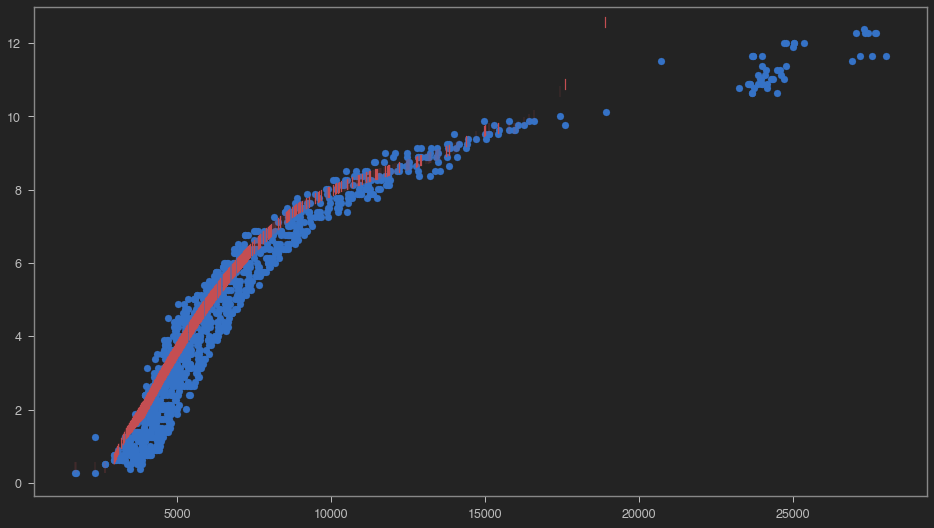

In [726]:
cursor = 0
mass_win_size = 10
bin_num = 2
last_rt_lo = 0.0

# plt.figure(figsize=(16, 9))
fig, ax = plt.subplots(1, figsize=(16, 9))
ax.scatter(df.Mass, df.RT)
filters = list()
while cursor < 20000:
    # do sth
#     print('processing win {}-{}'.format(cursor, cursor+mass_win_size))
    df_win = df[(df.Mass >= cursor) & (df.Mass < cursor + mass_win_size)]
    rt_lo, rt_hi = bin_range2(df_win, cursor, cursor+mass_win_size, f_hi2, f_lo2, bin_num)
    if rt_lo < last_rt_lo:
        rt_lo = last_rt_lo
        if rt_lo >= rt_hi:
            cursor += mass_win_size
            continue
            
    if np.isclose(rt_lo, 0.0) or np.isclose(rt_hi, 0.0):
        cursor += mass_win_size
        continue
    
    rect = create_rectangle(cursor, cursor+mass_win_size, rt_lo, rt_hi)
    ax.add_patch(rect)
    
    last_rt_lo = rt_lo
    df_filter = df_win[(df_win.RT>=rt_lo) & (df_win.RT<=rt_hi)]
#     print(cursor, df_filter.shape)
    filters.append(df_filter)
    cursor += mass_win_size

plt.show()

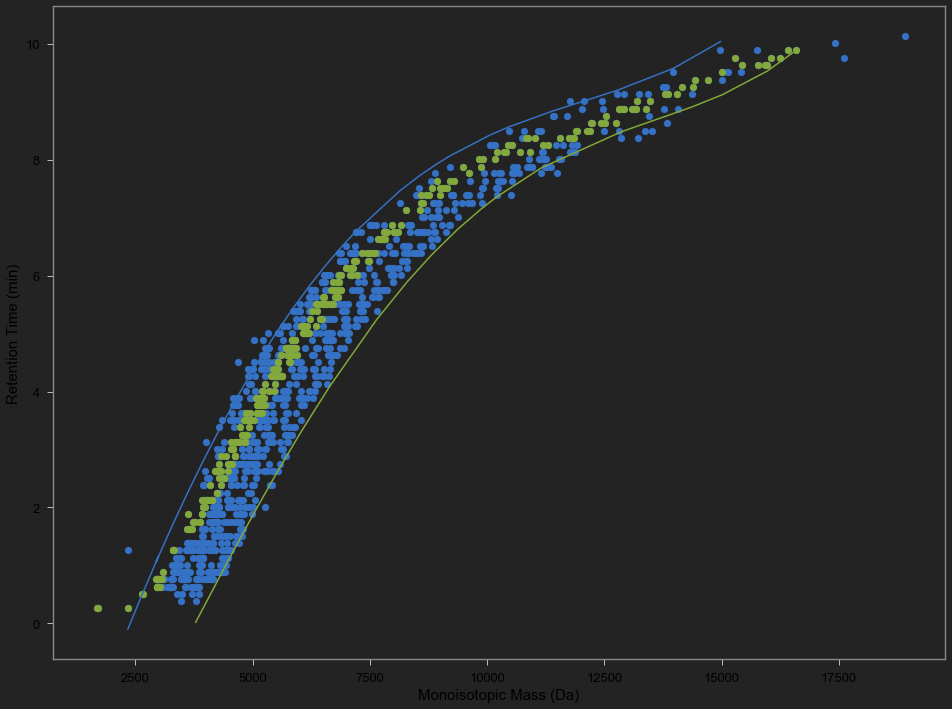

In [727]:
df_filters = pd.concat(filters)
plt = plot_zones(df[df.Mass<20000], df_filters)
plt.plot(df_hi.Mass, f_hi2(df_hi.Mass))
plt.plot(df_lo.Mass, f_lo2(df_lo.Mass))
plt.savefig('/Users/bryan/Documents/Presentations/Jan 12 2021/filter_{}_bin_{}_filters_{}.png'.format(filter_min, bin_num, filter_nums), transparent=True)

mass_x (163,) mass_y (163,)
df3_idxs 10 df5_idxs 10
df3_idxs 13 df5_idxs 13
df3_idxs 23 df5_idxs 23
df3_idxs 10 df5_idxs 10
df3_idxs 2 df5_idxs 2
df3_idxs 14 df5_idxs 14
df3_idxs 6 df5_idxs 6
df3_idxs 3 df5_idxs 3


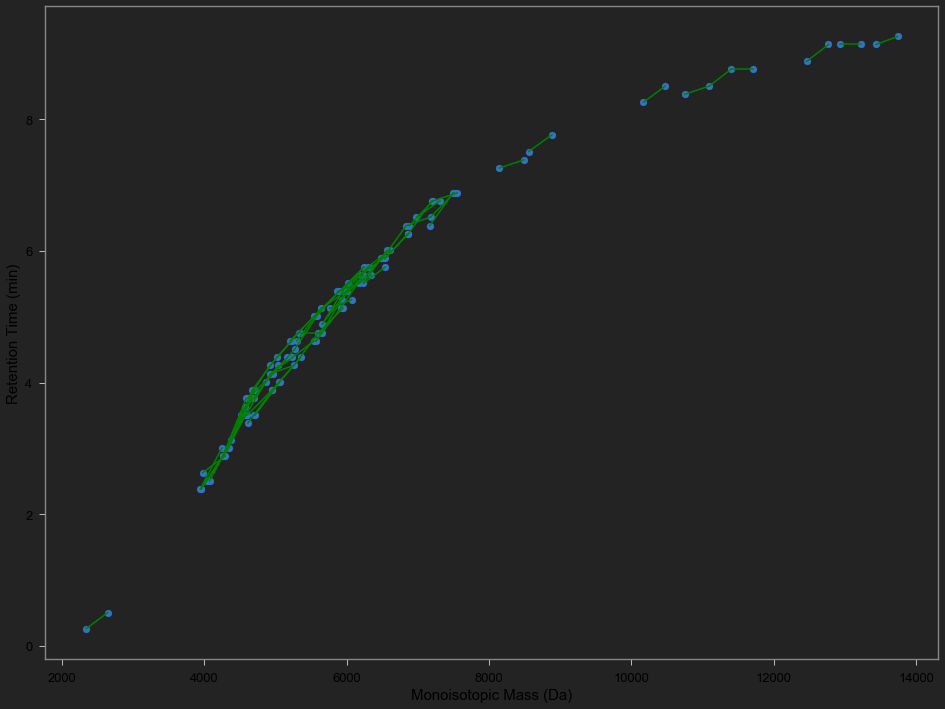

In [724]:
bcr_5p = base_calling_random(df_filters)
plt, _ = plot_basecalling(*bcr_5p, annotate=False)
plt.savefig('/Users/bryan/Documents/Presentations/Jan 12 2021/filter_bc_{}_bin_{}_filters_{}.png'.format(filter_min, bin_num, filter_nums), transparent=True)

In [725]:
G = nx.DiGraph()

df_bcr = bcr_5p[0]
mass_pairs = bcr_5p[1]
for t in mass_pairs:
#     df_pair = df_bcr[df_bcr.Mass.isin(t)]
#     if df_pair.empty:
#         continue
#     plt.plot(df_pair.Mass, df_pair.RT, 'green')
#     print(t)
#     G.add_path([t[1], t[0]])
    G.add_edge(t[1], t[0], base=t[-1])

path = longest_path(G)
seqs = [G.edges[path[i], path[i+1]]['base'] for i in range(len(path)-1)]
print('longest sequence: ' + ''.join(seqs))
print(path)

longest sequence: UAGDTGCc
[4037.52173740876, 4343.54757596686, 4672.60278881059, 5017.65158117102, 5325.69111054621, 5645.74414955476, 5990.78972018256, 6295.83153829269, 6614.86805325903]


In [562]:
import networkx as nx
def longest_path(G):
    dist = {} # stores [node, distance] pair
    for node in nx.topological_sort(G):
        # pairs of dist,node for all incoming edges
        pairs = [(dist[v][0]+1,v) for v in G.pred[node]] 
        if pairs:
            dist[node] = max(pairs)
        else:
            dist[node] = (0, node)
    node,(length,_)  = max(dist.items(), key=lambda x:x[1])
    path = []
    while length > 0:
        path.append(node)
        length,node = dist[node]
    return list(reversed(path))

In [708]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from descartes import PolygonPatch
import alphashape

def draw_fit_zone(df):
        df = df.sort_values(by='Mass')
        x = df['Mass']
        y = df['RT']
        plt.figure(figsize=(16, 12))
        plt.scatter(x, y)
        points = np.array([x, y]).T
        hull = ConvexHull(points)
#         fig, ax = plt.subplots(1, figsize=(16, 9))
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], '--', color='green')

        z = np.polyfit(x, y, 2)
        def f(x):
            return z[0]*x*x + z[1]*x + z[2]
        y = f(x)
        plt.plot(x, y, "r-")

        plt.show()

#         return df_invalid

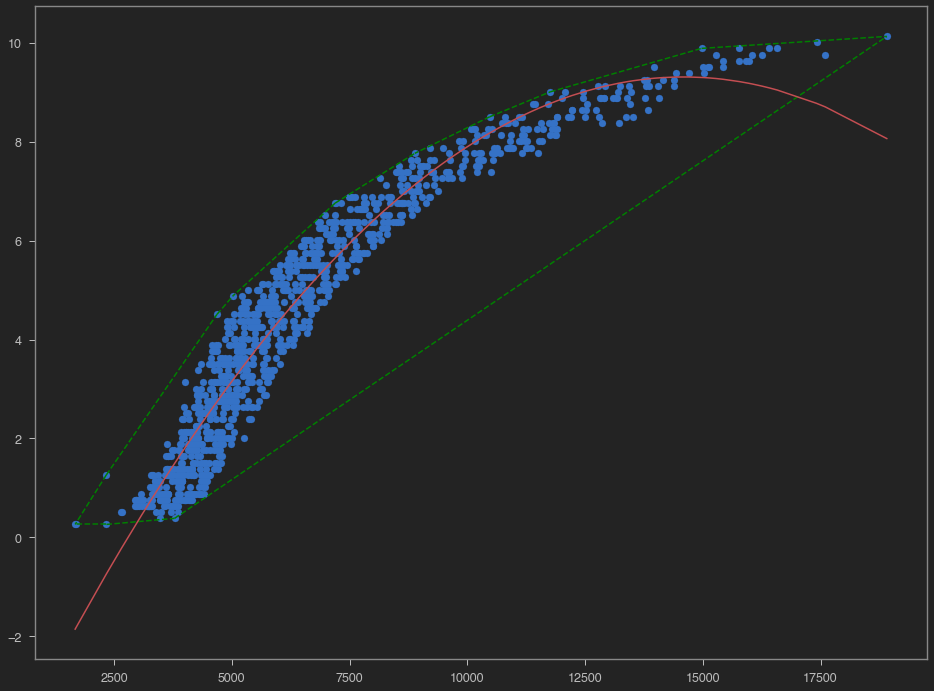

In [709]:
draw_fit_zone(df[df.Mass < 20000])

In [337]:
def alpha_shape_func(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [349]:
from scipy.spatial import Delaunay
df_win['RT1'] = df_win.RT * 1000
points = np.array(df_win[['Mass', 'RT1']])
# print(points)
edges = alpha_shape_func(points, 0.25, only_outer=False)
print(edges)

set()


/Users/bryan/Virtuals/vir_seq/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [475]:
idxs = list()
# create our callback function
def on_selection(trace, points, selector):
    print('points {}'.format(points.point_inds) )
    idxs.extend(points.point_inds)

def on_click(trace, points, selector):
#     print('points {}'.format(points.point_inds) )
    idxs.extend(points.point_inds)

df_sample = df[df.Mass < 20000]
f = zone_selection(df_sample, on_selection=on_selection, on_click=on_click)
f

FigureWidget({
    'data': [{'marker': {'color': [#6371f2, #6371f2, #6371f2, ..., #6371f2,
                   …

In [476]:
df_chosen = df_sample.iloc[idxs]
df_chosen.shape

(28, 3)

In [477]:
df_hi = df_chosen
# df_lo = df_chosen

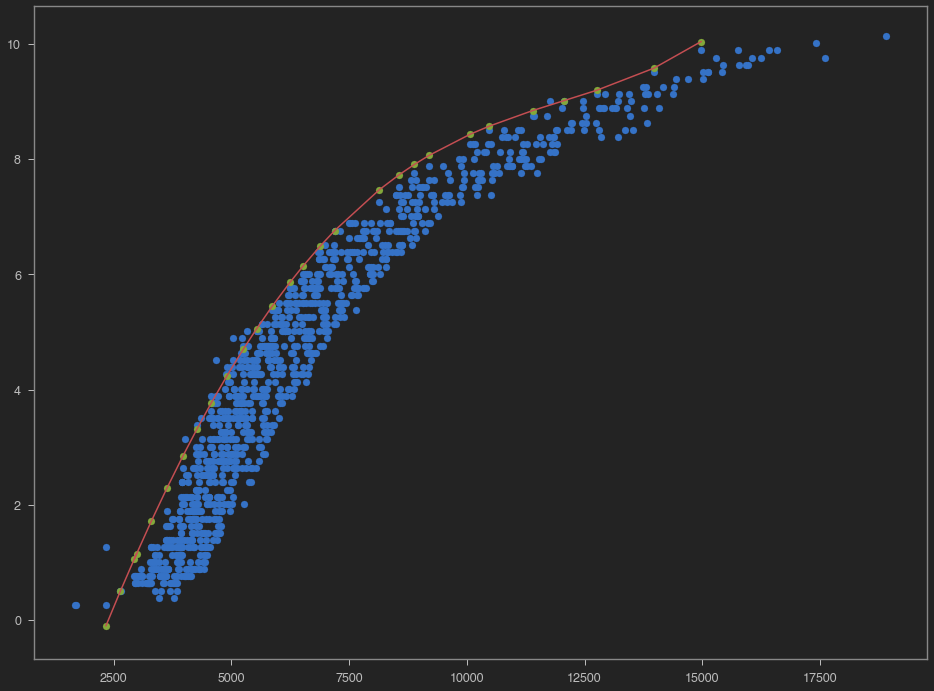

In [718]:
x = df_hi.Mass
y = df_hi.RT
z = np.polyfit(x, y, 4)
def f_hi2(x):
    return z[0] * x**4 + z[1]*x**3 + z[2]*x**2 + z[3]*x + z[4] + 0.1
y = f_hi2(x)
plt.figure(figsize=(16, 12))
plt.scatter(df_sample.Mass, df_sample.RT)
plt.plot(x, y, "r-")

plt.scatter(x, y)
plt.show()

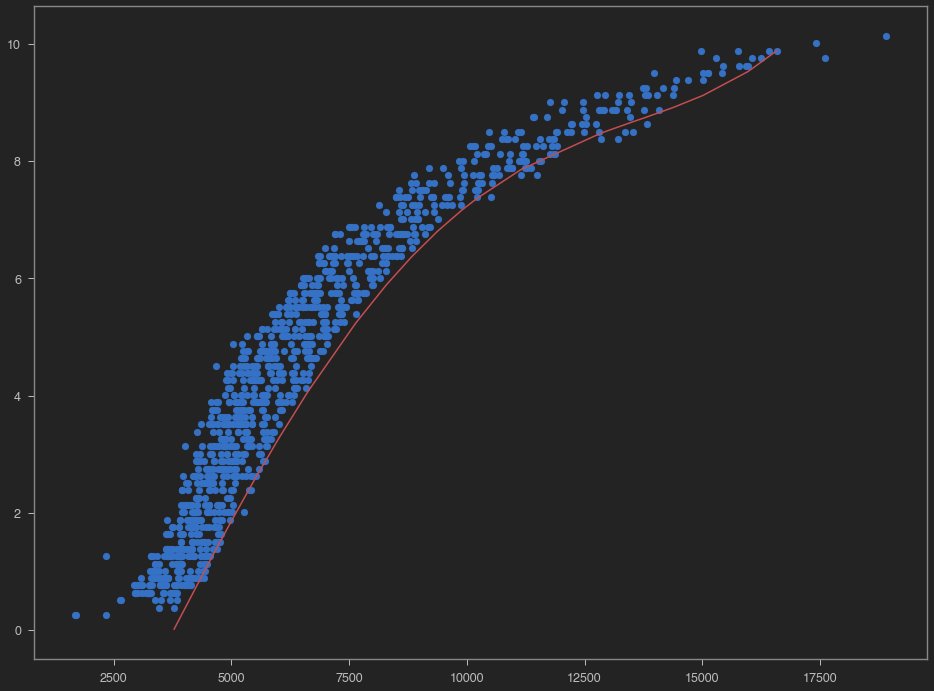

In [719]:
x = df_lo.Mass
y = df_lo.RT
# z_lo2 = np.polyfit(x, y, 4)
z_lo2 = np.polyfit(x, y, 4)
def f_lo2(x):
    return z_lo2[0] * x**4 + z_lo2[1]*x**3 + z_lo2[2]*x**2 + z_lo2[3]*x + z_lo2[4] - 0.1
#     return z_lo2[0] * x**4 + z_z_lo2lo[1]*x**3 + z_lo2[2]*x**2 + z_lo2[3]*x + z_lo2[4] - 0.1
#     return z_lo[0] * x**3 + z_lo[1]*x**2 + z_lo[2]*x + z_lo[3]
y = f_lo2(x)
plt.figure(figsize=(16, 12))
plt.scatter(df_sample.Mass, df_sample.RT)
plt.plot(x, y, "r-")
# plt.scatter(x, y)
plt.show()

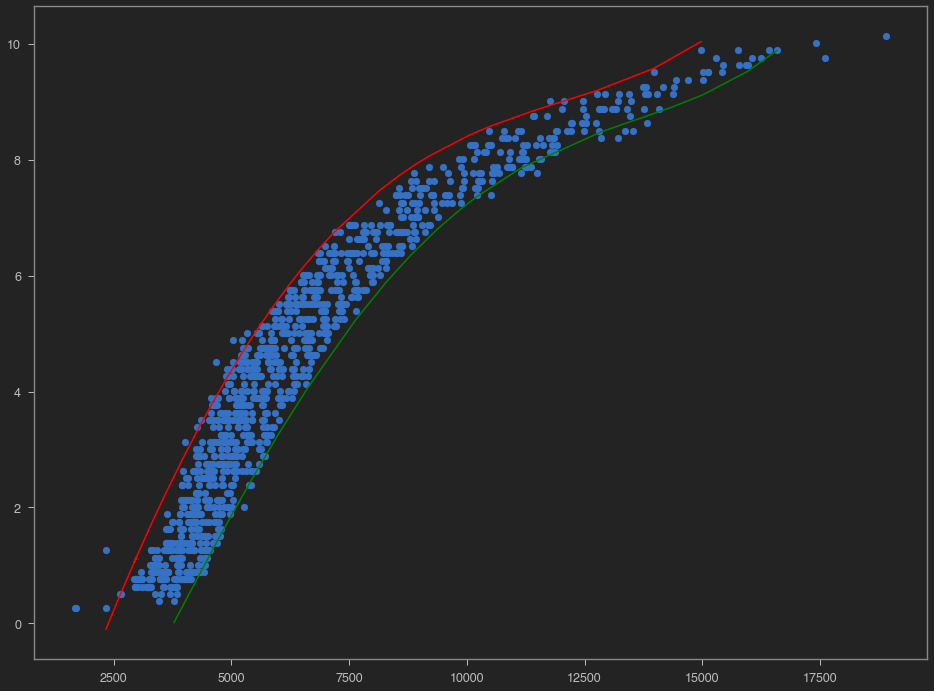

In [720]:
# plt = plot_zones(df_chosen, df_lo)
_, ax = plt.subplots(figsize=(16, 12))
ax.scatter(df_sample.Mass, df_sample.RT)

# ax.scatter(df_hi.Mass, df_hi.RT, c='red')
ax.plot(df_hi.Mass, f_hi2(df_hi.Mass), c='red')

# ax.scatter(df_lo.Mass, df_lo.RT, c='green')
ax.plot(df_lo.Mass, f_lo2(df_lo.Mass), c='green')

# Bezier Curve
# nodes_hi = np.array(df_hi[['Mass', 'RT']]).T
# num_hi = df_chosen.shape[0]
# curve_hi = bezier.Curve(nodes_hi, degree=num_hi-1)
# curve_hi.plot(num_hi, ax=ax)

# nodes_lo = np.array(df_lo[['Mass', 'RT']]).T
# num_lo = df_lo.shape[0]
# curve_lo = bezier.Curve(nodes_lo, degree=num_lo-1)
# curve_lo.plot(num_lo, ax=ax)

In [429]:
import bezier

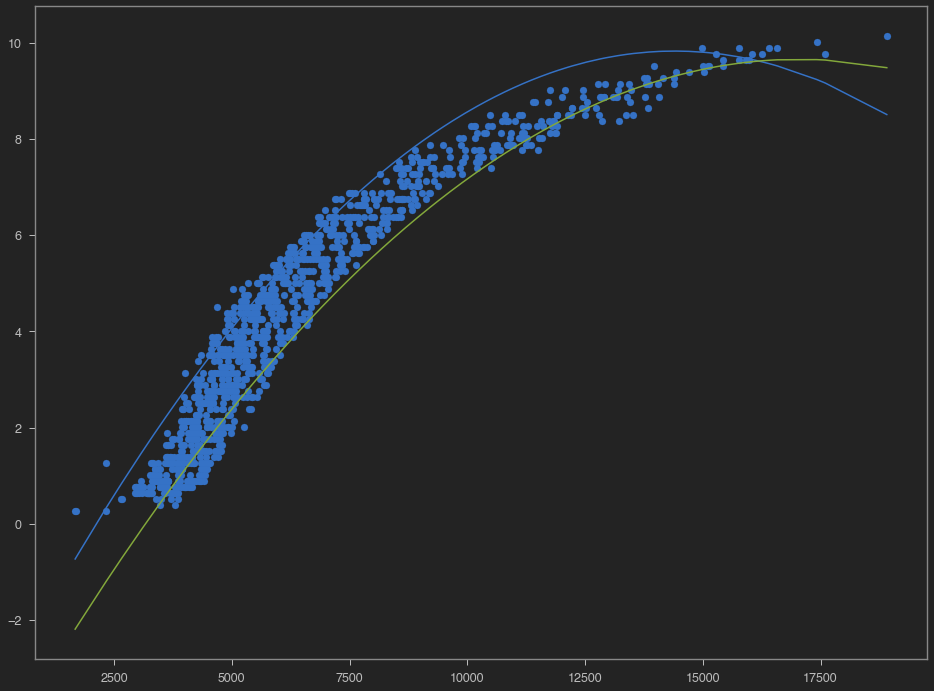

In [427]:
df_sample = df[df.Mass < 20000]
plt.figure(figsize=(16, 12))
plt.scatter(df_sample.Mass, df_sample.RT)
x = df_sample.Mass.sort_values()
plt.plot(x, f_hi(x))
plt.plot(x, f_lo(x))
